<a href="https://colab.research.google.com/github/Luke-Chesley/MLB-Game-Outcome-Predictive-Model/blob/main/MLB_ridge_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Can a model be built with ridge regression using run differential and home field advantage to predict the outcome of games? 
* This model achieves ~60% accuracy after ratings stabilize ~1/3 of the way through the season. 
* Model performs better when taking into account errors made by teams

This model uses the "adjusted plus/minus rating system" created by Dan Rosenbaum (http://www.82games.com/comm30.htm) and the implementaiton is based off this article (https://towardsdatascience.com/how-to-improve-sports-betting-odds-step-by-step-guide-in-python-94626b852f45) 

A team being home or away is the independent viariable and the run differential is the target variable. lr.coef_ is the expected run differential for each team at a netural stadium. lr.intercept_ is the 'home field advantage' run differential. This is added to the home team's expected run differential to predict outcomes of games. 
* lr.coef_, or the expected run differential, is what I am calling the team ratings  

 # Team "ratings"

Import libraries

In [1]:
import pandas as pd
import requests
import numpy as np
from operator import delitem
import csv
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
!pip install matplotlib-label-lines
from labellines import labelLine, labelLines
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Get data from API in JSON format

In [2]:
url = "https://v1.baseball.api-sports.io/games?league=1&season=2022"

payload={}
headers = {
  'x-rapidapi-key': '1ae57e7a748cd2bb05d6fd7321c4747a',
  'x-rapidapi-host': 'v1.baseball.api-sports.io'
}

response = requests.request("GET", url, headers=headers, data=payload)

data = response.json()

y = data.get('response')


Function to parse JSON

In [3]:
def game_results(num):
  
  y = data.get('response')
  x = (y[num]).get('teams')

  a = x.get('away')
  b = x.get('home')

  away_team = a.get('name')
  home_team = b.get('name')


  z = (y[num]).get('scores')

  c = z.get("home")
  d = z.get('away')

  home_score = c.get('total')
  away_score = d.get('total')

  date = (y[num]).get('date')



  return(date, home_team,home_score, away_team, away_score)



Create blank CSV then write function data to CSV


In [4]:
blank = pd.DataFrame(list())
blank.to_csv('data.csv')

csv_file = open("data.csv", 'w')

csv_writer = csv.writer(csv_file, delimiter=",")

for i in range(len(y)):
  csv_writer.writerow(game_results(i))

csv_file.close()

Getting CSV data into Data Frame (last 2 lines needed in some years)

In [5]:
df = pd.read_csv('data.csv')

df.columns = ['date', 'home', 'home_runs', 'away','away_runs']

df['date'] = pd.to_datetime(df['date'])


df['run_difference'] = df['home_runs'] - df['away_runs']

df['home_win'] = np.where(df['run_difference'] < 0,1,0)
df['home_loss'] = np.where(df['run_difference'] > 0,1,0)

df = df[380:] #drop spring training games


df_visitor = pd.get_dummies(df['away'], dtype=np.int64)
df_home = pd.get_dummies(df['home'], dtype=np.int64)


df_model = df_home.sub(df_visitor)
df_model['run_difference'] = df['run_difference']




df_model = df_model.drop('American League', axis=1)
df_model = df_model.drop('National League', axis=1)

Function to clean data (drops null values)

In [6]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame)
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


df_model = clean_dataset(df_model)


Training ridge regression

In [7]:
df_train = df_model

lr = Ridge(alpha=.001) 
X = df_train.drop(['run_difference'], axis=1)

y = df_train['run_difference']


lr.fit(X,y)


Ridge(alpha=0.001)

Show sorted coefficents

In [8]:
df_ratings = pd.DataFrame(data={'team': X.columns, 'rating': lr.coef_})
df_ratings.sort_values(by=['rating'], ascending=False)

,team,rating
13,Los Angeles Dodgers,1.782345
18,New York Yankees,1.506281
10,Houston Astros,1.240209
1,Atlanta Braves,0.887084
17,New York Mets,0.824390
25,St.Louis Cardinals,0.752576
28,Toronto Blue Jays,0.613926
26,Tampa Bay Rays,0.449910
24,Seattle Mariners,0.400734
20,Philadelphia Phillies,0.370637


# Team rating over the season

Re load df

In [9]:
df = pd.read_csv('data.csv')

df.columns = ['date', 'home', 'home_runs', 'away','away_runs']

df['date'] = pd.to_datetime(df['date'])


df['run_difference'] = df['home_runs'] - df['away_runs']

df['home_win'] = np.where(df['run_difference'] < 0,1,0)
df['home_loss'] = np.where(df['run_difference'] > 0,1,0)
df = df.drop(axis=0, index=1875)

df = df[380:] #drop spring training games

intercept_list = [] # list to keep track of the intercepts (home field advantage)


df_rating_list = pd.DataFrame()


Team rating for each team in 10 game increments

In [10]:
for i in range(50, len(df), 10):
  df_visitor = pd.get_dummies(df['away'][0:i], dtype=np.int64)
  df_home = pd.get_dummies(df['home'][0:i], dtype=np.int64)


  df_model = df_home.sub(df_visitor)
  df_model['run_difference'] = df['run_difference'][0:i]


  df_train = clean_dataset(df_model)

  lr = Ridge(alpha=0.001) 
  X = df_train.drop(['run_difference'], axis=1)

  y = df_train['run_difference']


  lr.fit(X,y)


  df_ratings = pd.DataFrame(data={'team': X.columns, 'rating': lr.coef_})

  df_ratings = df_ratings.transpose()

  df_ratings = df_ratings.rename(columns=df_ratings.iloc[0]).drop(df_ratings.index[0])

  df_rating_list = df_rating_list.append(df_ratings)

  intercept_list.append(lr.intercept_)



  df_visitor = pd.DataFrame()
  df_home = pd.DataFrame()
  df_model = pd.DataFrame()
  df_train = pd.DataFrame()
  X = pd.DataFrame()
  y = pd.DataFrame()


In [11]:
intercept_list = pd.Series(intercept_list)

Clean df_rating_list and format it for graphing

In [12]:
df_rating_list.reset_index()
df_rating_list['game'] = np.arange(0, len(df_rating_list))
df_rating_list['game'] = (df_rating_list['game'] - df_rating_list['game'].min()) / (df_rating_list['game'].max() - df_rating_list['game'].min())
df_rating_list.set_index(df_rating_list['game'], inplace=True)
df_rating_list.rename(columns={'game': 'date'}, inplace=True)
df_rating_list.drop(columns='date', inplace=True)

Graph every team's rating. Excluding noise in first 20% of season and unplayed games in last 11% of season

[Text(0.2545322580645161, -0.0424479278377459, 'Arizona Diamondbacks'),
 Text(0.27456451612903227, -0.5032234847996693, 'Atlanta Braves'),
 Text(0.2945967741935484, -0.530175190423553, 'Baltimore Orioles'),
 Text(0.31462903225806454, 0.23792158673017857, 'Boston Red Sox'),
 Text(0.33466129032258063, -0.5473726291137339, 'Chicago Cubs'),
 Text(0.35469354838709677, -1.1479191731423675, 'Chicago White Sox'),
 Text(0.3747258064516129, -0.66957021492387, 'Cincinnati Reds'),
 Text(0.39475806451612905, 0.04722104332978064, 'Cleveland Guardians'),
 Text(0.4147903225806452, -1.044387236093003, 'Colorado Rockies'),
 Text(0.4348225806451613, -1.1058423284457073, 'Detroit Tigers'),
 Text(0.45485483870967747, 0.919009351393837, 'Houston Astros'),
 Text(0.4748870967741936, -1.3197125593017545, 'Kansas City Royals'),
 Text(0.49491935483870975, 0.23947682366352688, 'Los Angeles Angels'),
 Text(0.5149516129032258, 1.2712971254928995, 'Los Angeles Dodgers'),
 Text(0.5349838709677419, -0.1119107819835886

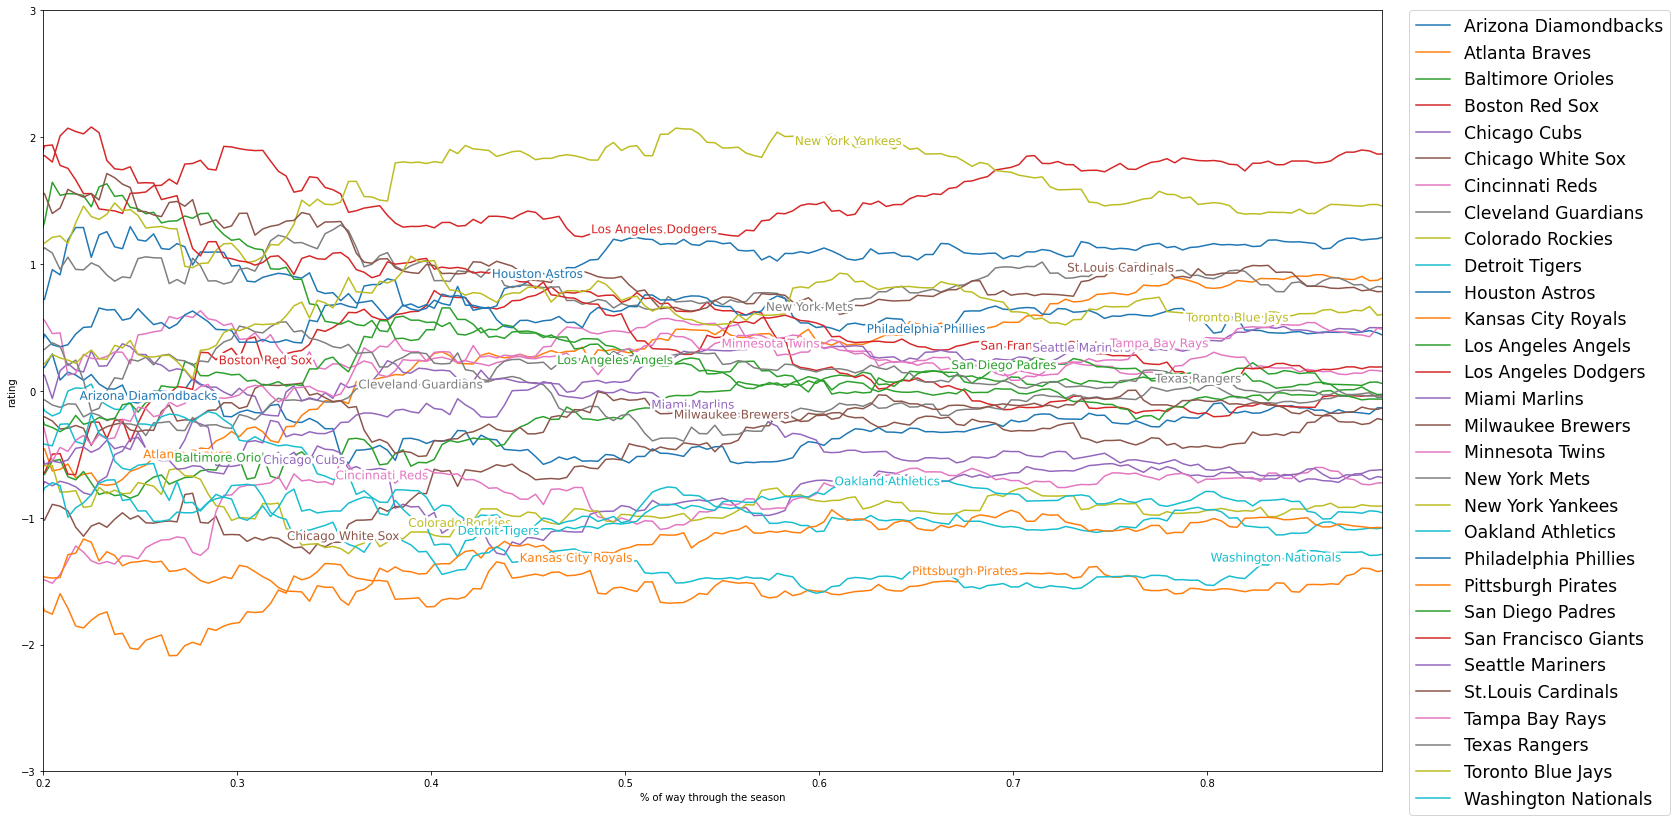

In [13]:
df_rating_list.plot.line(figsize=(24,14), sort_columns=True)
plt.xlim([0.2,0.89])
plt.ylim([-3,3])
plt.xlabel('% of way through the season')
plt.ylabel('rating')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='xx-large')


labelLines(align=False, fontsize=12)

Graph specific teams to make it easier to read

[Text(0.31607142857142856, 0.31688151080358395, 'Boston Red Sox'),
 Text(0.39964285714285713, 0.04557030583139123, 'Cleveland Guardians'),
 Text(0.4832142857142857, 0.5625065543452553, 'Philadelphia Phillies'),
 Text(0.5667857142857142, 1.8810268480928758, 'New York Yankees'),
 Text(0.6503571428571429, -1.552952521712381, 'Pittsburgh Pirates'),
 Text(0.7339285714285714, 1.773620787071047, 'Los Angeles Dodgers')]

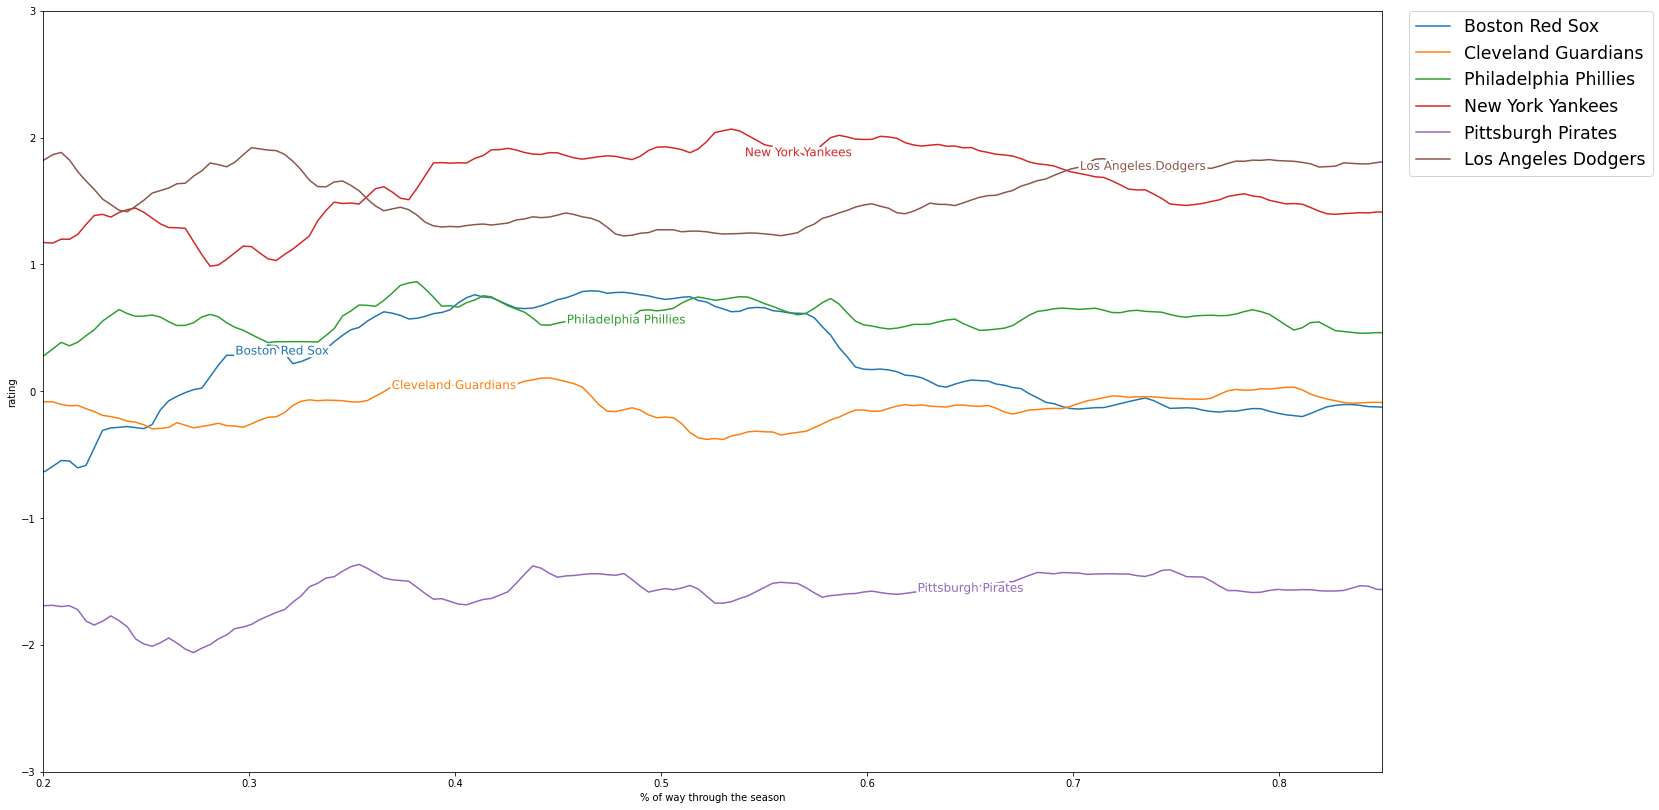

In [15]:
df_rating_list[['Boston Red Sox', 'Cleveland Guardians', 'Philadelphia Phillies', 'New York Yankees', 'Pittsburgh Pirates', 'Los Angeles Dodgers']].rolling(3).mean().plot.line(figsize=(24,14), sort_columns=True)
plt.xlim([0.2,0.85])
plt.ylim([-3,3])
plt.xlabel('% of way through the season')
plt.ylabel('rating')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='xx-large')


labelLines(align=False, fontsize=12)

# Accuracy of model
Did the team with the higher rating actually win? This was true about 60% of the time.

Re load df

In [16]:
df = pd.read_csv('data.csv')
df.columns = ['date', 'home', 'home_runs', 'away','away_runs']
df = df.drop(axis=0, index=1875) # drop all star game
df['date'] = pd.to_datetime(df['date'])

df = df[380:] #drop spring training games

Exclude first 1/3 of games from the evaluation

In [17]:
third = int(len(df) / 3)
df = df[third:].reset_index()
df = df.dropna(axis=0)

Function to help match games by the % of the way through the season

In [18]:
def closest(lst, K):
      
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

Function to determine if model prediceted correct result

In [19]:
def model_eval(index):
  home_runs = df['home_runs'][index]
  away_runs = df['away_runs'][index]
  if home_runs > away_runs:
    true_winner = df['home'][index]
  else:
    true_winner = df['away'][index]

  home_pred = df_rating_list[df['home'][index]][closest(df_rating_list.index, (index/len(df) + third / len(df)))] + closest(intercept_list.array, (index/len(df) + third / len(df))) # third / len(df) is added back becuase df_rating_list was not shortened by 1/3

  away_pred = df_rating_list[df['away'][index]][closest(df_rating_list.index, (index/len(df) + third / len(df)))]

  if home_pred > away_pred:
    pred_winner = df['home'][index]
  else:
    pred_winner = df['away'][index]
  
  if true_winner == pred_winner:
    return 1
  else:
    return 0


List of results for every game. 1 for correct, 0 for incorrect

In [20]:
results_list = []
for i in range(len(df)):
  results_list.append(model_eval(i))

Accuracy of model at the end of the season

In [21]:
accuracy_of_model = sum(results_list) / len(results_list)
accuracy_of_model

0.6052467207995003

Accuracy of model at each game duing the season

In [22]:
accuracy_over_time = []

for i in range(1, len(results_list)):
  test_list = results_list[0:i]
  accuracy_of_model = sum(test_list) / len(test_list)
  accuracy_over_time.append(accuracy_of_model)
  

Round the values and convert to pd.DataFrame for graphing

In [23]:
accuracy_over_time = [round(i, 4) for i in accuracy_over_time]
accuracy_over_time = pd.DataFrame(accuracy_over_time)

Average accuracy at each game during the season

In [24]:
accuracy_over_time.mean()

0    0.602269
dtype: float64

Plot accuracy over the season

In [25]:
lobf = accuracy_over_time[50:1750].reset_index()
lobf.columns = ['game', 'rating']
lobf_X = lobf['game']
lobf_y = lobf['rating']
theta = np.polyfit(lobf_X, lobf_y, 1)
y_line = theta[1] + theta[0] * lobf_X

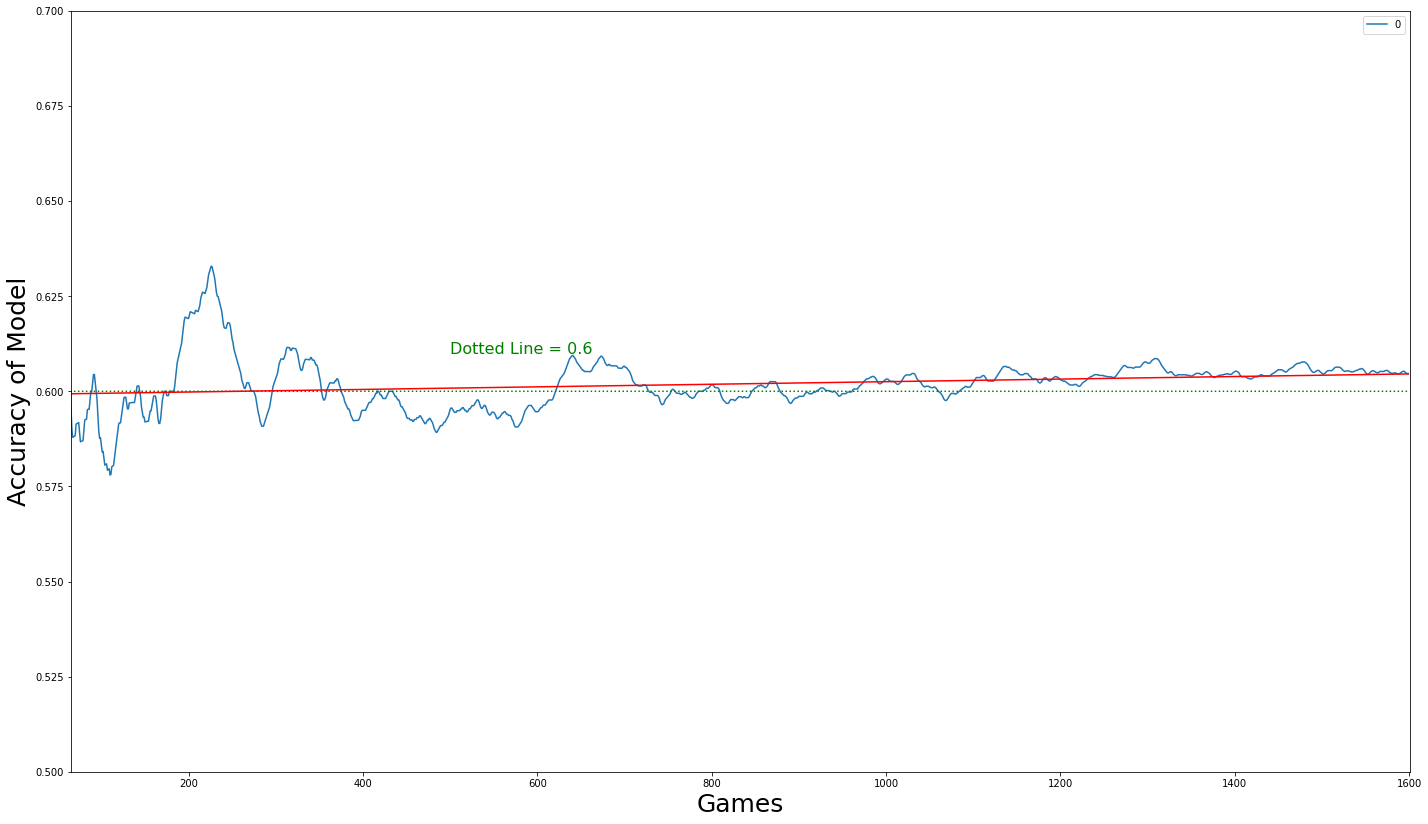

In [26]:
accuracy_over_time.rolling(5).mean().plot.line(figsize=(24,14), sort_columns=True)
plt.xlim([65,len(df)])
plt.ylim([0.5,0.7])
plt.xlabel('Games', fontsize = 25)
plt.ylabel('Accuracy of Model', fontsize = 25)
plt.plot(pd.DataFrame([[0.6]] * len(accuracy_over_time)), ls='dotted', color='green' )
plt.text(500, 0.61, 'Dotted Line = 0.6', color='green', fontsize=16)
plt.plot(lobf_X, y_line, 'r') # LOBF

The model gets more accurate as the season progresses as show by the line of best fit. 

The accuracy also becomes more stable as the season progresses as shown by ln( accuracy_over_time / y_line) 

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


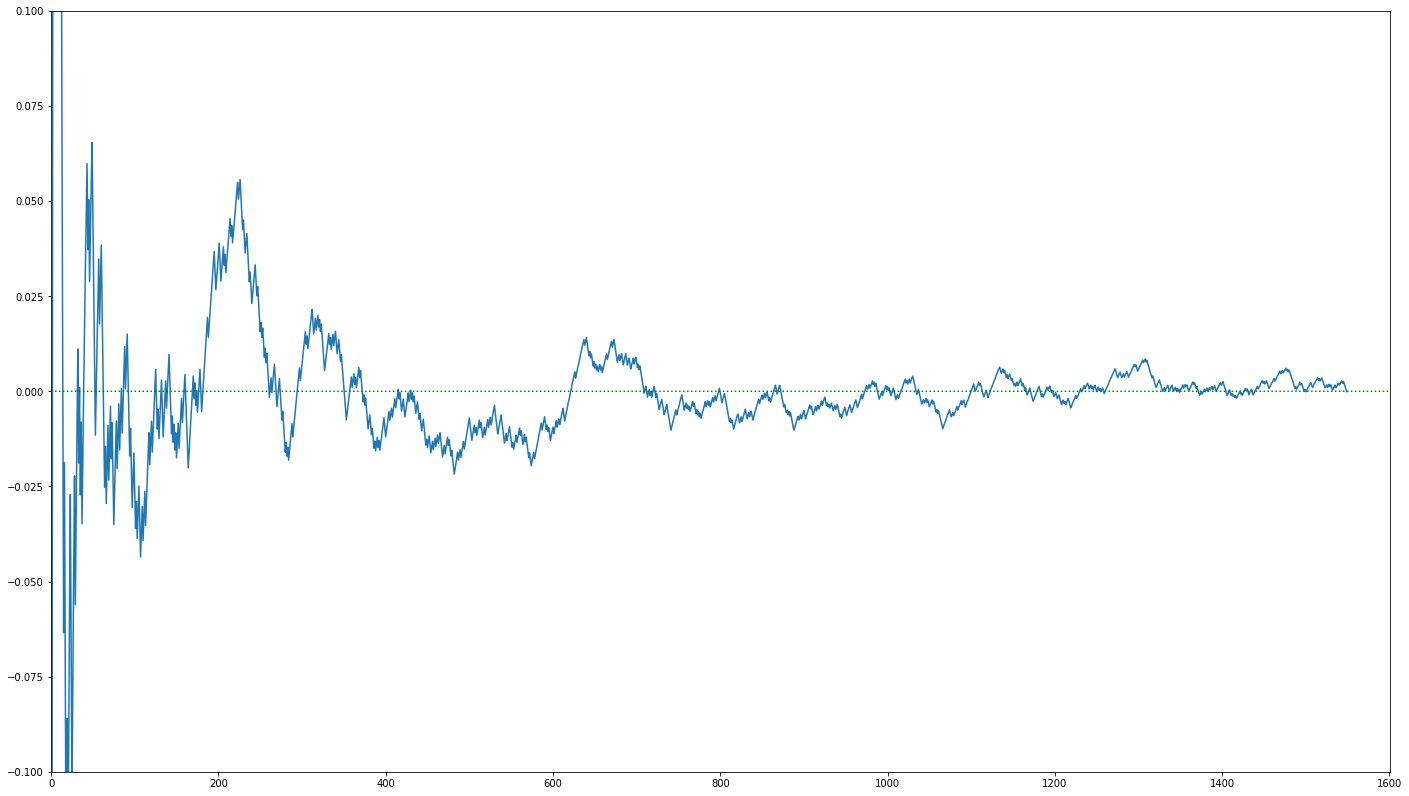

In [50]:
accuracy_over_time = accuracy_over_time.squeeze()
y_line =  pd.Series(y_line)
divided = np.log(accuracy_over_time / y_line)
divided = pd.DataFrame(divided)
divided[0].plot.line(figsize=(24,14))
plt.xlim([0,len(df)])
plt.ylim([-0.1,0.1])
plt.plot(pd.DataFrame([[0]] * len(accuracy_over_time)), ls='dotted', color='green' )


# Model with error bouns

According to an article (https://calltothepen.com/2018/08/23/baseball-statistics-impact-errors-pitching/) analyzing errors made in the 2017 season, the impact of an error that season was a 22 point (0.022) increase in on base average in the inning an error was made. 
* Does this increase in on base average lead to winning more games by a wider margin? 
* To incorperate this in the model, for every error a team made their opponent's run total was increased by an error bonus 
* error_bouns = num_of_opponent_errors * (0.022 / 9)
* This error bonus was found to have a negligible impact on the results so the error bouns was increased to num_of_opponent_errors * 0.75
* This punishes a team for making errors much more than what has been otherwise found
* The coefficients were only slightly impacted and the model performed slighlty better than without taking errors into account
* Other error_bouns constants were tried and 0.75 was found to be close to the optimal value to make the model perform the best



* Accuracy with error_bouns is 61.22%
* Accuracy without is 59.71%

Re load data

In [28]:
url = "https://v1.baseball.api-sports.io/games?league=1&season=2022"

payload={}
headers = {
  'x-rapidapi-key': '1ae57e7a748cd2bb05d6fd7321c4747a',
  'x-rapidapi-host': 'v1.baseball.api-sports.io'
}

response = requests.request("GET", url, headers=headers, data=payload)

data = response.json()

y = data.get('response')


Adjust parsing function

In [29]:
def game_results_with_errors(num):
  
  y = data.get('response')
  x = (y[num]).get('teams')

  a = x.get('away')
  b = x.get('home')

  away_team = a.get('name')
  home_team = b.get('name')




  z = (y[num]).get('scores')

  c = z.get("home")
  d = z.get('away')

  home_score = c.get('total')
  away_score = d.get('total')


  away_errors = d.get('errors')
  home_errors = c.get('errors')

  date = (y[num]).get('date')





  return(date, home_team,home_score, away_team, away_score, home_errors, away_errors)


Adjust file name

In [30]:
blank = pd.DataFrame(list())
blank.to_csv('data_error.csv')

csv_file = open("data_error.csv", 'w')

csv_writer = csv.writer(csv_file, delimiter=",")

for i in range(len(y)):
  csv_writer.writerow(game_results_with_errors(i))

csv_file.close()

Define Error Bonus

In [31]:
error_bonus = 0.75

Re load df

In [32]:
df_with_errors = pd.read_csv('data_error.csv')

df_with_errors.columns = ['date', 'home', 'home_runs', 'away','away_runs', 'home_errors', 'away_errors']

df_with_errors['date'] = pd.to_datetime(df['date'])


df_with_errors['run_difference'] = df_with_errors['home_runs'] - df_with_errors['away_runs']

df_with_errors['home_win'] = np.where(df_with_errors['run_difference'] < 0,1,0)
df_with_errors['home_loss'] = np.where(df_with_errors['run_difference'] > 0,1,0)

error_bonus = error_bonus

df_with_errors['adjusted_home_runs'] = df_with_errors['home_runs'] + df_with_errors['away_errors']* error_bonus
df_with_errors['adjusted_away_runs'] = df_with_errors['away_runs'] + df_with_errors['home_errors']* error_bonus

df_with_errors['adjusted_run_difference'] = df_with_errors['adjusted_home_runs'] - df_with_errors['adjusted_away_runs']
df_with_errors = df_with_errors.drop(axis=0, index=1875) # drop all star game
df_with_errors['date'] = pd.to_datetime(df_with_errors['date'])

df_with_errors = df_with_errors[380:]

intercept_list_with_errors = [] # list to keep track of the intercepts (home field advantage)


df_rating_list_with_errors = pd.DataFrame()


Team rating with adjusted run totals in 10 game increments

In [33]:
for i in range(50, len(df_with_errors), 10):
  df_visitor = pd.get_dummies(df_with_errors['away'][0:i], dtype=np.int64)
  df_home = pd.get_dummies(df_with_errors['home'][0:i], dtype=np.int64)


  df_model = df_home.sub(df_visitor)
  df_model['adjusted_run_difference'] = df_with_errors['adjusted_run_difference'][0:i]


  df_train = clean_dataset(df_model)

  lr = Ridge(alpha=0.001) 
  X = df_train.drop(['adjusted_run_difference'], axis=1)

  y = df_train['adjusted_run_difference']


  lr.fit(X,y)


  df_ratings_with_errors = pd.DataFrame(data={'team': X.columns, 'rating': lr.coef_})

  df_ratings_with_errors = df_ratings_with_errors.transpose()

  df_ratings_with_errors = df_ratings_with_errors.rename(columns=df_ratings_with_errors.iloc[0]).drop(df_ratings_with_errors.index[0])

  df_rating_list_with_errors = df_rating_list_with_errors.append(df_ratings_with_errors)

  intercept_list_with_errors.append(lr.intercept_)

  df_visitor = pd.DataFrame()
  df_home = pd.DataFrame()
  df_model = pd.DataFrame()
  df_train = pd.DataFrame()
  X = pd.DataFrame()
  y = pd.DataFrame()


In [34]:
intercept_list_with_errors = pd.Series(intercept_list_with_errors)

Cleaning and formating df_rating_list_with_errors

In [35]:
df_rating_list_with_errors.reset_index()
df_rating_list_with_errors['game'] = np.arange(0, len(df_rating_list_with_errors))
df_rating_list_with_errors['game'] = (df_rating_list_with_errors['game'] - df_rating_list_with_errors['game'].min()) / (df_rating_list_with_errors['game'].max() - df_rating_list_with_errors['game'].min())
df_rating_list_with_errors.set_index(df_rating_list_with_errors['game'], inplace=True)
df_rating_list_with_errors.rename(columns={'game': 'date'}, inplace=True)
df_rating_list_with_errors.drop(columns='date', inplace=True)

Adjust model_eval

In [36]:
def model_eval_error(index):
  home_runs = df_with_errors['adjusted_home_runs'][index]
  away_runs = df_with_errors['adjusted_away_runs'][index]
  if home_runs > away_runs:
    true_winner = df_with_errors['home'][index]
  else:
    true_winner = df_with_errors['away'][index]

  home_pred = df_rating_list_with_errors[df_with_errors['home'][index]][closest(df_rating_list_with_errors.index, (index/len(df_with_errors) + third / len(df_with_errors)))] + closest(intercept_list_with_errors.array, (index/len(df_with_errors) + third / len(df_with_errors))) # third / len(df) is added back becuase df_rating_list was not shortened by 1/3

  away_pred = df_rating_list_with_errors[df_with_errors['away'][index]][closest(df_rating_list_with_errors.index, (index/len(df_with_errors) + third / len(df_with_errors)))]

  if home_pred > away_pred:
    pred_winner = df_with_errors['home'][index]
  else:
    pred_winner = df_with_errors['away'][index]
  
  if true_winner == pred_winner:
    return 1
  else:
    return 0


Re state df_with_error 

In [37]:
df_with_errors = pd.read_csv('data_error.csv')

df_with_errors.columns = ['date', 'home', 'home_runs', 'away','away_runs', 'home_errors', 'away_errors']

df_with_errors['date'] = pd.to_datetime(df['date'])


df_with_errors['run_difference'] = df_with_errors['home_runs'] - df_with_errors['away_runs']

df_with_errors['home_win'] = np.where(df_with_errors['run_difference'] < 0,1,0)
df_with_errors['home_loss'] = np.where(df_with_errors['run_difference'] > 0,1,0)

error_bonus = error_bonus

df_with_errors['adjusted_home_runs'] = df_with_errors['home_runs'] + df_with_errors['away_errors']* error_bonus
df_with_errors['adjusted_away_runs'] = df_with_errors['away_runs'] + df_with_errors['home_errors']* error_bonus

df_with_errors['adjusted_run_difference'] = df_with_errors['adjusted_home_runs'] - df_with_errors['adjusted_away_runs']
df_with_errors = df_with_errors.drop(axis=0, index=1875) # drop all star game
df_with_errors['date'] = pd.to_datetime(df_with_errors['date'])

df_with_errors = df_with_errors[380:].reset_index() 

third = int(len(df_with_errors) / 3)
df_with_errors = df_with_errors[third:].reset_index()
df_with_errors = df_with_errors.dropna(subset=['away_runs'])

List of results (correct pred or not) for every game. 1 for correct, 0 for incorrect



In [38]:
results_list_with_error = []
for i in range(len(df_with_errors)):
  results_list_with_error.append(model_eval_error(i))

Accuracy of model at the end of the season

In [39]:
accuracy_of_model_with_errors = sum(results_list_with_error) / len(results_list_with_error)
accuracy_of_model_with_errors

0.6096189881324172

Accuracy of model at each game duing the season

In [40]:
accuracy_over_time_with_errors = []

for i in range(1, len(results_list_with_error)):
  test_list_with_errors = results_list_with_error[0:i]
  accuracy_of_model_with_errors = sum(test_list_with_errors) / len(test_list_with_errors)
  accuracy_over_time_with_errors.append(accuracy_of_model_with_errors)
  

Round the values and convert to pd.DataFrame for graphing

In [41]:
accuracy_over_time_with_errors = [round(i, 4) for i in accuracy_over_time_with_errors]
accuracy_over_time_with_errors = pd.DataFrame(accuracy_over_time_with_errors)

Average accuracy at each game during the season



In [42]:
accuracy_over_time_with_errors.mean()

0    0.614737
dtype: float64

Plot accuracy over the season
* With trend line

Calculate trend line

In [43]:
lobf_error = accuracy_over_time_with_errors[50:1750].reset_index()
lobf_error.columns = ['game', 'rating']
lobf_error_X = lobf_error['game']
lobf_error_y = lobf_error['rating']
theta_error = np.polyfit(lobf_error_X, lobf_error_y, 1)
y_line_error = theta_error[1] + theta_error[0] * lobf_error_X

Plot

Text(250, 0.595, 'Dotted Line = 0.6')

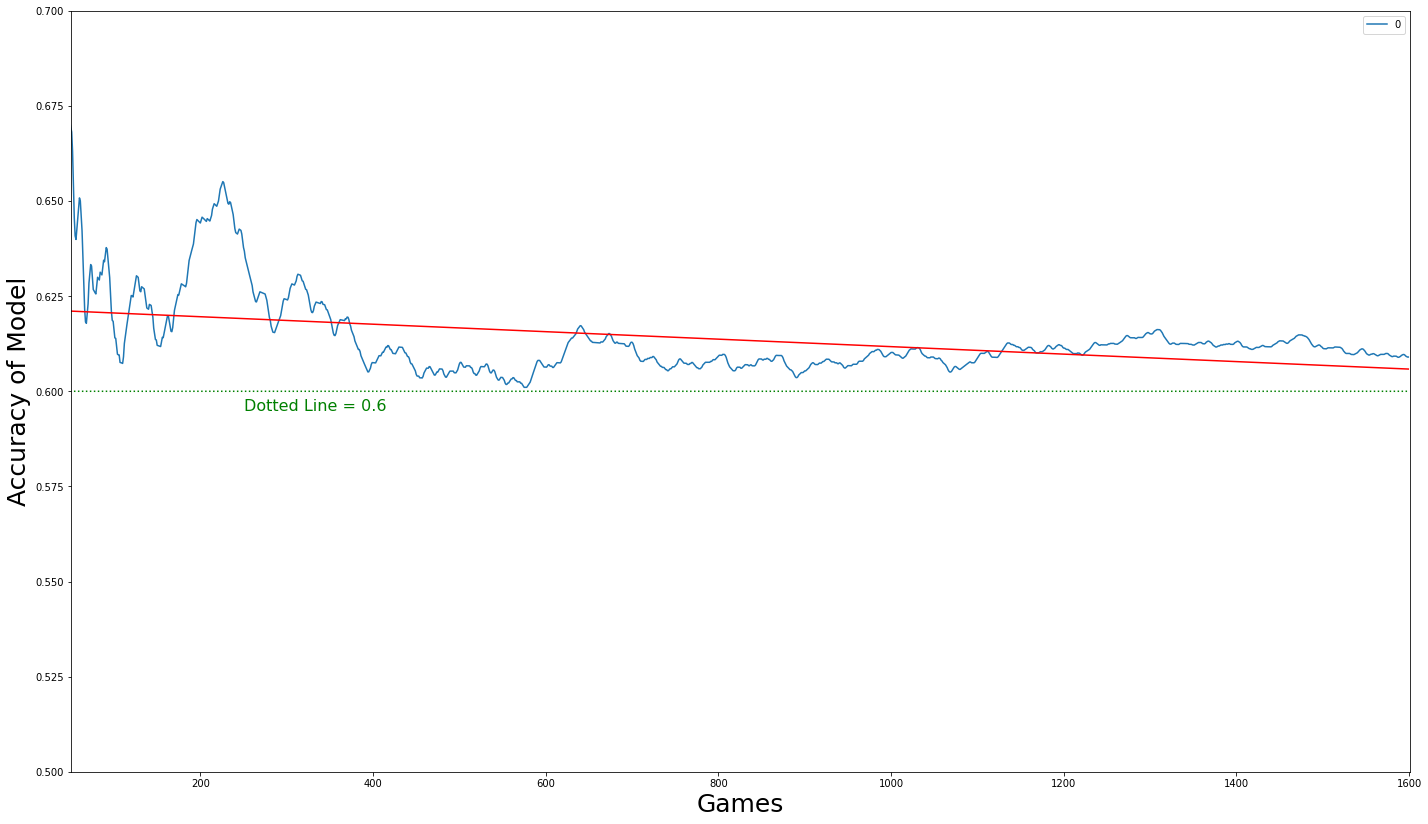

In [44]:
accuracy_over_time_with_errors.rolling(5).mean().plot.line(figsize=(24,14), sort_columns=True)
plt.xlim([50,len(df_with_errors)])
plt.ylim([0.5,0.7])
plt.xlabel('Games', fontsize = 25)
plt.ylabel('Accuracy of Model', fontsize = 25)
plt.plot(pd.DataFrame([[0.6]] * len(accuracy_over_time_with_errors)), ls='dotted', color='green' )

plt.plot(lobf_error_X, y_line_error, 'r') # LOBF

plt.text(250, 0.595, 'Dotted Line = 0.6', color='green', fontsize=16)



/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


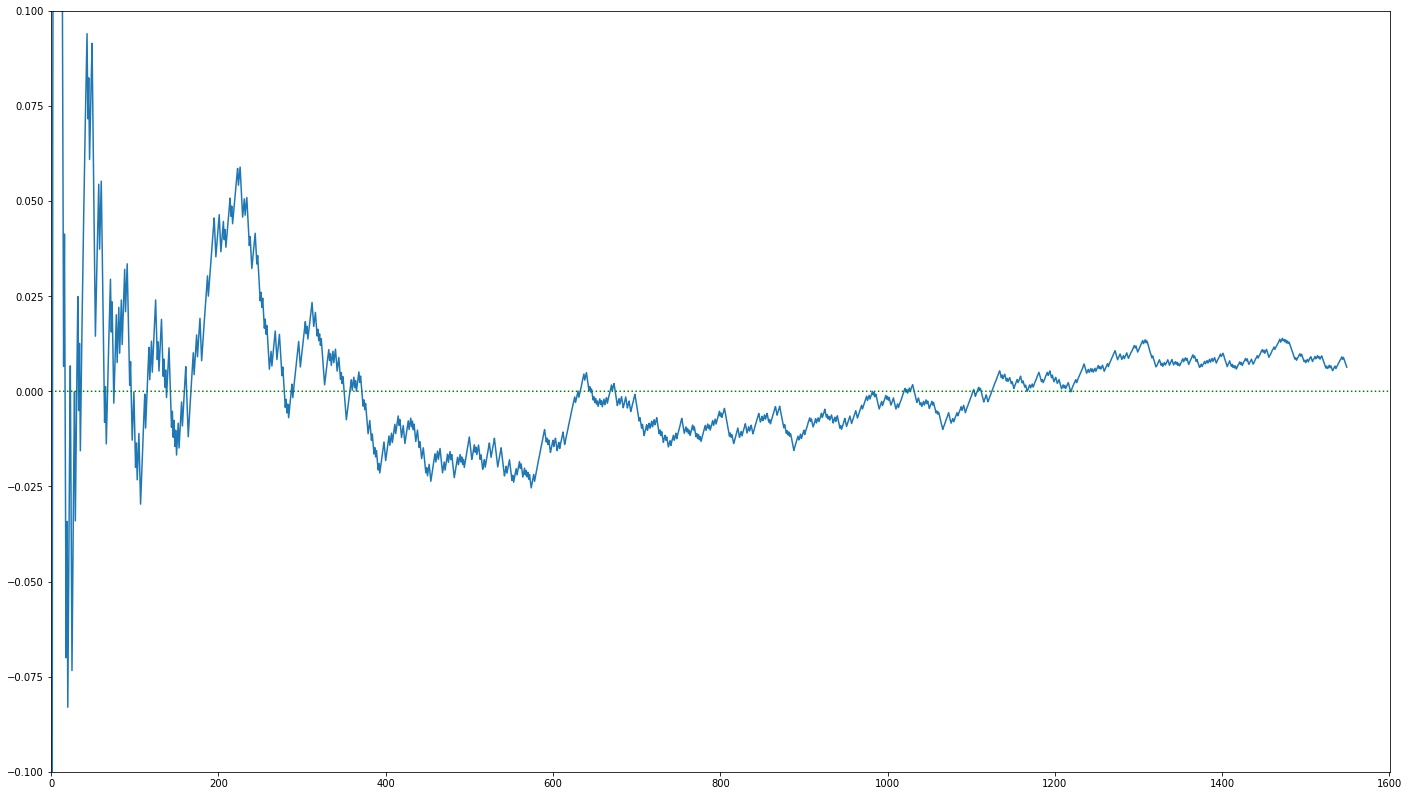

In [53]:
accuracy_over_time_with_errors = accuracy_over_time_with_errors.squeeze()
y_line_error =  pd.Series(y_line_error)
divided_error =  np.log(accuracy_over_time_with_errors / y_line_error)
divided_error = pd.DataFrame(divided_error)
divided_error[0].plot.line(figsize=(24,14), sort_columns=True)
plt.xlim([0,len(df_with_errors)])
plt.ylim(-0.1,0.1)
plt.plot(pd.DataFrame([[0]] * len(accuracy_over_time)), ls='dotted', color='green' )


Taking errors into account increases the accuracy by about 1% compared to the model not taking errors into account, and acheives this consistency sooner, with no clear increase as the season progresses

# Limitations of Model

Not very robust. More than one model should be used if any weight will be put on the results.

This only takes into account 2 features. More features should be taken into account to increase accuracy. 
* Examples: Pitchers ERA, number of days rest, result of last game/ last 10 games, starting lineup batting average 

The error bonus is completly arbitrary and was back fit to produce the best results.

More years of MLB data should be analyzed to look for trends from year to year.